In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
# from sklearn.decomposition import PCA

<br>
<left><b><font size=4>Section 1 – Data exploration and pre-processing<b><left>

Dataset of all the SSH sessions

In [2]:
if not os.path.isfile("ssh_attacks_decoded_splitted.parquet"):
    raise Exception("You should run the preprocessing file")
df = pd.read_parquet("ssh_attacks_decoded_splitted.parquet")

**1. When are the attacks performed? Analyze the temporal series.**

In [3]:
# Creating a new DataFrame containing only attack instances
# Excluding sessions labeled as "Harmless" with a single label
df_attacks = df.loc[~df["Set_Fingerprint"].apply(lambda session : "Harmless" in session and len(session) == 1)]
attacks_per_day = df_attacks['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_of_attacks_per_day")

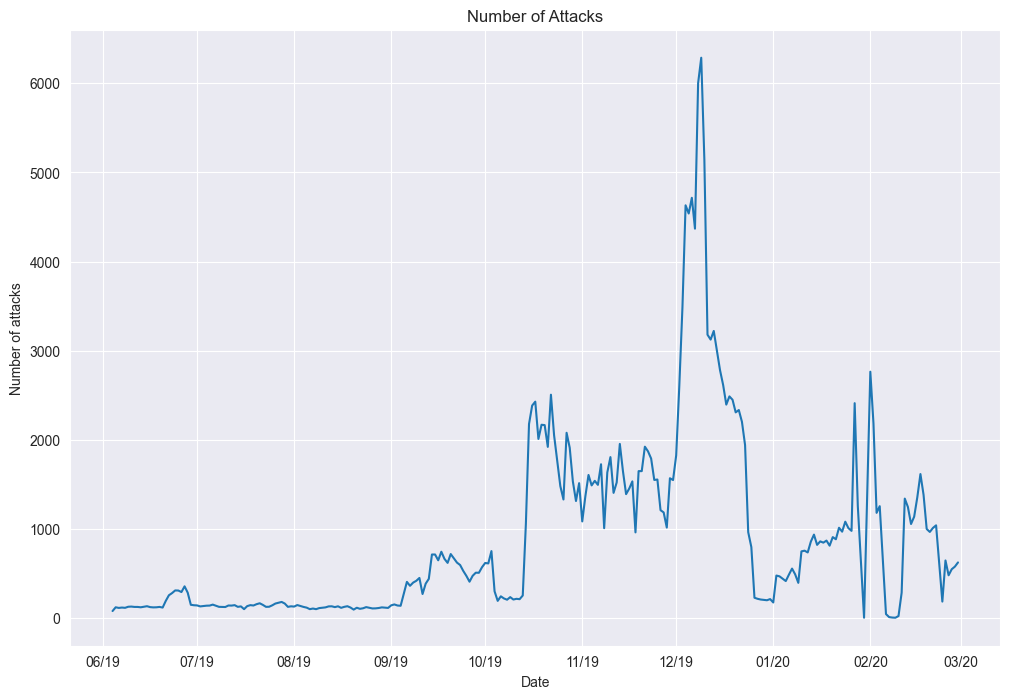

In [4]:
plt.figure(figsize=(12,8))
sns.set_style("darkgrid")

sns.lineplot(
    data = attacks_per_day,
    linestyle='-',
    color= 'blue',
    legend=False
)

plt.title('Number of Attacks')
plt.xlabel("Date")
plt.ylabel("Number of attacks")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.show()

The visualization depicting attack frequencies over time reveals distinct patterns:

Between June 2019 and September 2019, there is a conspicuous decrease in attack occurrences, indicating a phase of minimal activity. Subsequently, there is a significant surge in attack instances towards the latter part of 2019, signifying a notable rise in both the frequency and intensity of attacks during this period.

This timeline underscores a stark contrast between the relatively quiet phase observed from June to September 2019 and the pronounced escalation in attack activities, particularly notable in the latter months of the year. This shift in trend emphasizes a substantial alteration in attack behavior, marked by an extended period of low activity succeeded by a considerable surge in attack incidents towards the year's end.

Moreover, at the beginning of 2020, there is a noticeable decline in attack occurrences once more. This decline follows the heightened activity observed in late 2019, representing a shift from the increased attack rates back to a decreased frequency as the year transitions into its initial months.

In [5]:
attacks_per_year = df_attacks.groupby(df['first_timestamp'].dt.year).size().to_frame("Number_attacks").reset_index()
attacks_per_year.rename(columns={"first_timestamp": "Year"}, inplace=True)

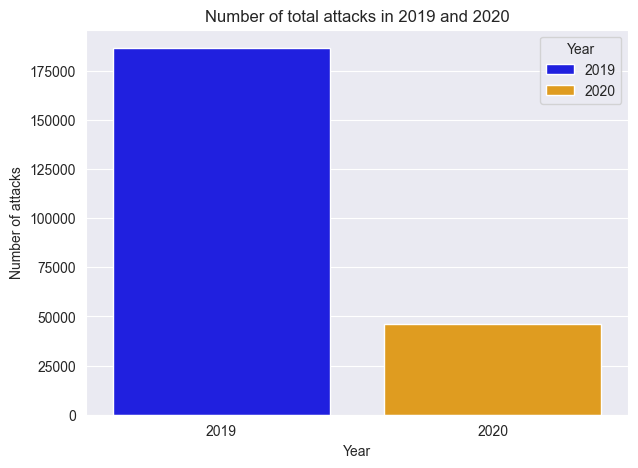

In [6]:
plt.figure(figsize=(7,5))
sns.barplot(
    data = attacks_per_year,
    x = "Year",
    y = "Number_attacks",
    hue= "Year",
    palette = ['blue','orange']
)

plt.ylabel("Number of attacks")
plt.title("Number of total attacks in 2019 and 2020")
plt.show()

The contrast in attack counts between the two years, with 2019 showing a significantly higher number of attacks compared to 2020, can be reasonably attributed to the limited temporal coverage of the dataset for the year 2020. With data available for only two months of 2020, the reduced number of observations in this period is expected and explains the lower count of attacks for that year compared to the extensive records available for 2019.

In [7]:
df_attacks_2019 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2019]
df_attacks_2019_month = df_attacks_2019.groupby(df_attacks_2019["first_timestamp"].dt.month).size().to_frame("Number_attacks_2019_month").reset_index()

df_attacks_2020 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2020]
df_attacks_2020_month = df_attacks_2020.groupby(df_attacks_2020["first_timestamp"].dt.month).size().to_frame("Number_attacks_2020_month").reset_index()

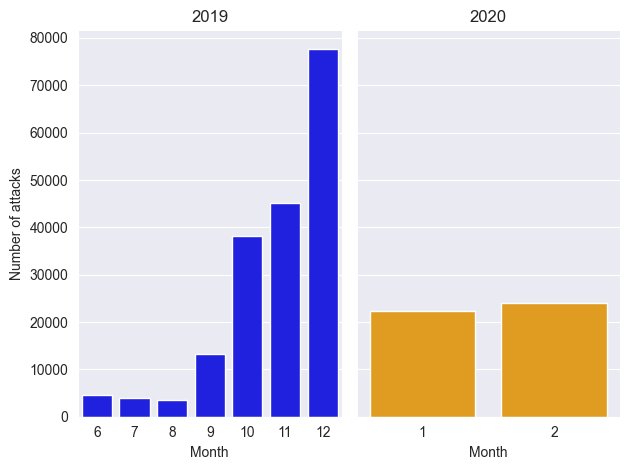

In [8]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(1,2 ,sharey=True)
plt.subplot(1,2,1)
sns.barplot(
    data = df_attacks_2019_month,
    x = "first_timestamp",
    y = "Number_attacks_2019_month",
    ax=axes[0],
    color = 'blue'  
)
plt.title("2019")
plt.xlabel("Month")
plt.ylabel("Number of attacks")

plt.subplot(1,2,2)
sns.barplot(
    data = df_attacks_2020_month,
    x = "first_timestamp",
    y = "Number_attacks_2020_month",
    ax=axes[1],
    color = 'orange'
)
plt.title("2020")
plt.xlabel("Month")
plt.ylabel("Number of attacks")

plt.tight_layout()
plt.show()

The bar charts reveal intriguing trends:

- In 2019, there is a noticeable surge in the number of attacks from months 9 to 12. A progressive increase in attack activity is observed during these months, reaching a peak towards the year's end.

- At the onset of 2020, in months 1 and 2, a relatively similar frequency of attacks is noted, approximately representing half the number of attacks compared to month 10 in 2019.

These patterns outline a significant uptick in attack activity towards the end of 2019, followed by a comparatively steady beginning in 2020 with a considerably lower number of attacks compared to the peak period of the previous year.

**1.2. Extract features from the attack sessions. How does the empirical distribution of the number of
characters in each session look like? How is the distribution of the number of word per session?**

In [9]:
# Calculate the number of characters and words in each session

number_words = df['full_session'].apply(lambda session: len(session))
number_characters = df['full_session'].apply(lambda session: sum([len(word) for word in session]))

data = {"number_characters": number_characters, "number_words": number_words}
df_number_characters_words = pd.DataFrame(data = data)

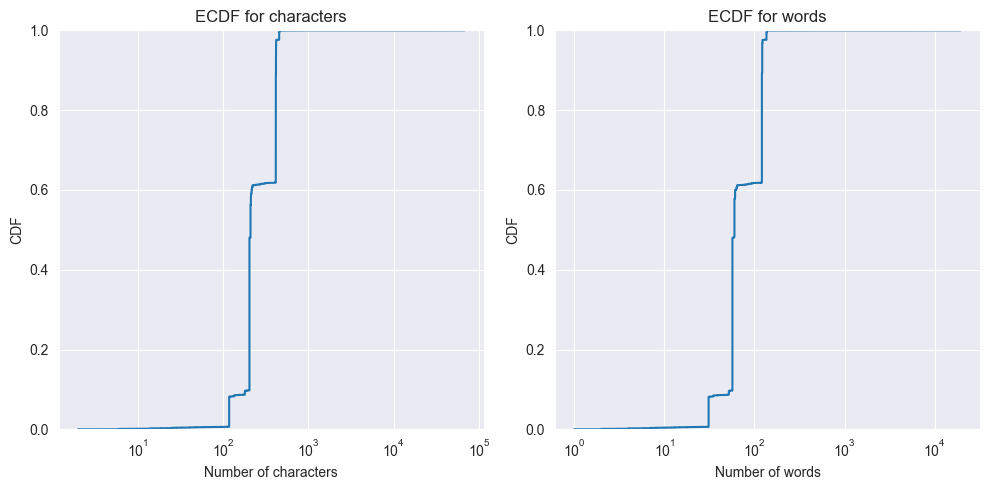

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.ecdfplot(
    data = df_number_characters_words['number_characters'],
    log_scale=True
)
plt.title("ECDF for characters")
plt.xlabel("Number of characters")
plt.ylabel("CDF")

plt.subplot(1,2,2)
sns.ecdfplot(
    data = df_number_characters_words['number_words'],
    log_scale=True
)
plt.title("ECDF for words")
plt.xlabel("Number of words")
plt.ylabel("CDF")

plt.tight_layout()
plt.show()

From the plot it's possible to see that the distribution of characters and words per session predominantly are concetrated between 10<sup>2</sup> and 10<sup>3</sup>. It has been used the logarithm scale because there is a few sessions with a lot of characters/words

**1.3. What are the most common words in the sessions?**

In [15]:
all_words = df["full_session"].explode()

In [16]:
df_most_common_words = all_words.value_counts().head(10)
most_common_word = df_most_common_words.idxmax()
frequency = df_most_common_words.max()
word_freq=df_most_common_words.to_dict()
print(f"The most  common word is: {most_common_word}")

The most  common word is: tmp


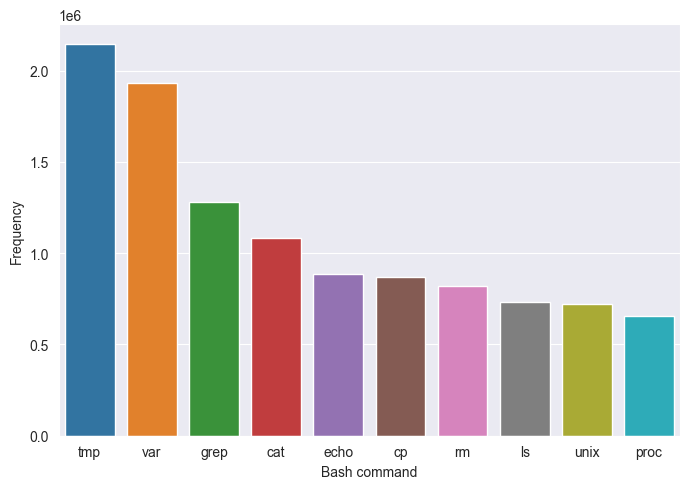

In [13]:
plt.figure(figsize=(7,5))
sns.barplot(
    data = pd.DataFrame([word_freq]),
)
plt.xlabel("Bash command")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

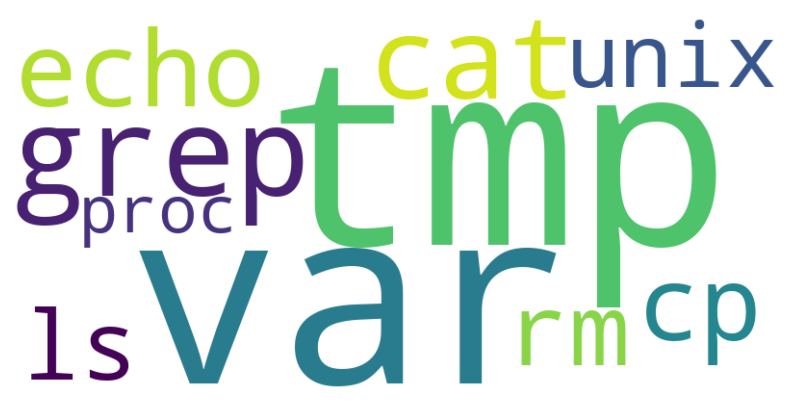

In [14]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

 This representation emphasizes words based on their frequency in the sessions. Words that appear more frequently will be displayed larger and more prominently within the WordCloud. The interpolation='bilinear' argument enhances the image quality for better clarity. The plt.axis('off') command removes the axis for a cleaner visual appearance.

**1.4. How are the intents distributed? How many intents per session do you observe? What are the most common intents? How are the intents distributed in time?**

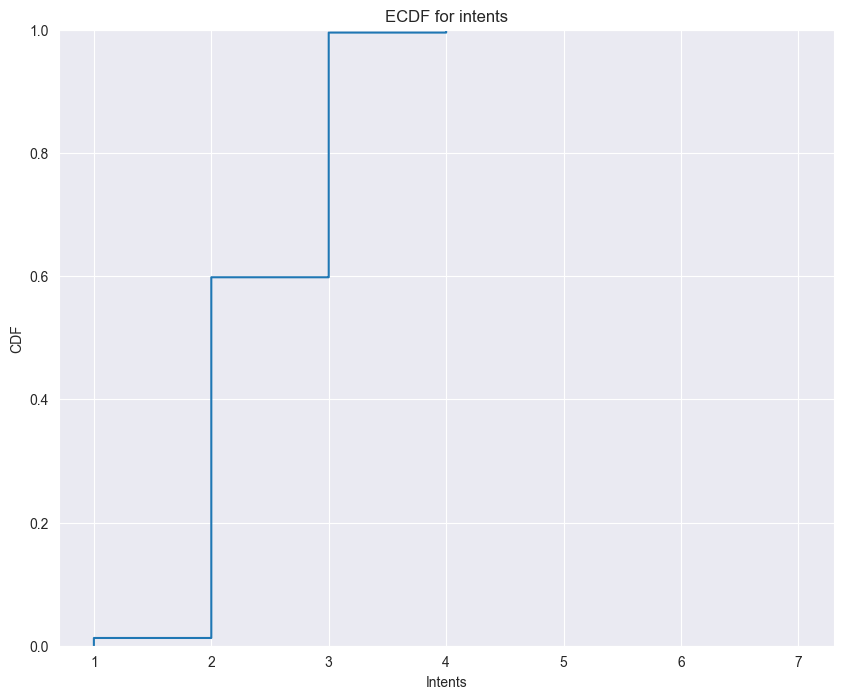

In [19]:
df_intents = df[["session_id", "first_timestamp", "Set_Fingerprint"]]

# Expanding the 'Set_Fingerprint' column to individual intents and sessions
df_intents_exploted = df_intents.explode('Set_Fingerprint')
intents_df_grouped = df_intents_exploted.groupby("session_id").size().to_frame("Number_of_intents")

plt.figure(figsize=(10,8))
sns.ecdfplot(
    data = intents_df_grouped,
    legend=False
)
plt.title("ECDF for intents")
plt.xlabel("Intents")
plt.ylabel("CDF")
plt.show()

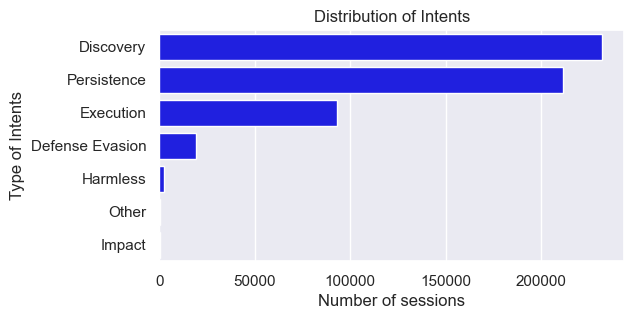

In [20]:
intents = df_intents_exploted.groupby('Set_Fingerprint').size().sort_values(ascending=False).to_frame("Number_of_sessions")
sns.set_theme(style="darkgrid")
plt.figure(figsize=(6,3))
sns.barplot(intents, x="Number_of_sessions", y=intents.index, color="blue", hue_order=intents.index)
plt.title('Distribution of Intents')
plt.xlabel('Number of sessions')
plt.ylabel('Type of Intents')

plt.show()

The presented bar chart shows the most common intentions found in the dataset; Discovery, Persistence and Execution lead the most used type of attacks for each of the sessions.

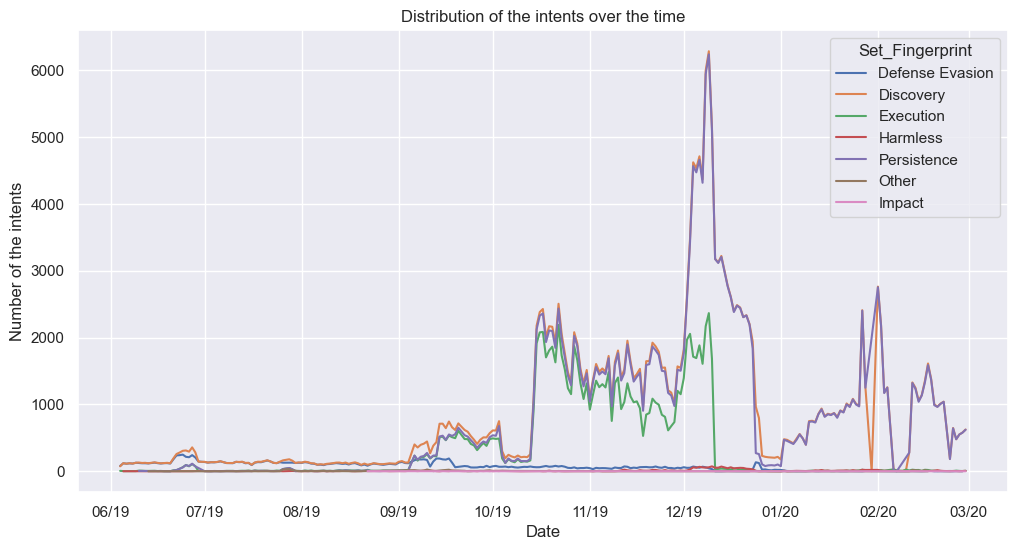

In [21]:
df_intents_distribution = df_intents_exploted.groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().to_frame("Number_of_intents").reset_index()
df_intents_distribution
plt.figure(figsize=(12, 6))
sns.lineplot(
    data = df_intents_distribution,
    x = "first_timestamp",
    y = "Number_of_intents",
    hue="Set_Fingerprint",
    legend=True
)
plt.title("Distribution of the intents over the time")
plt.xlabel("Date")
plt.ylabel("Number of the intents")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

plt.show()

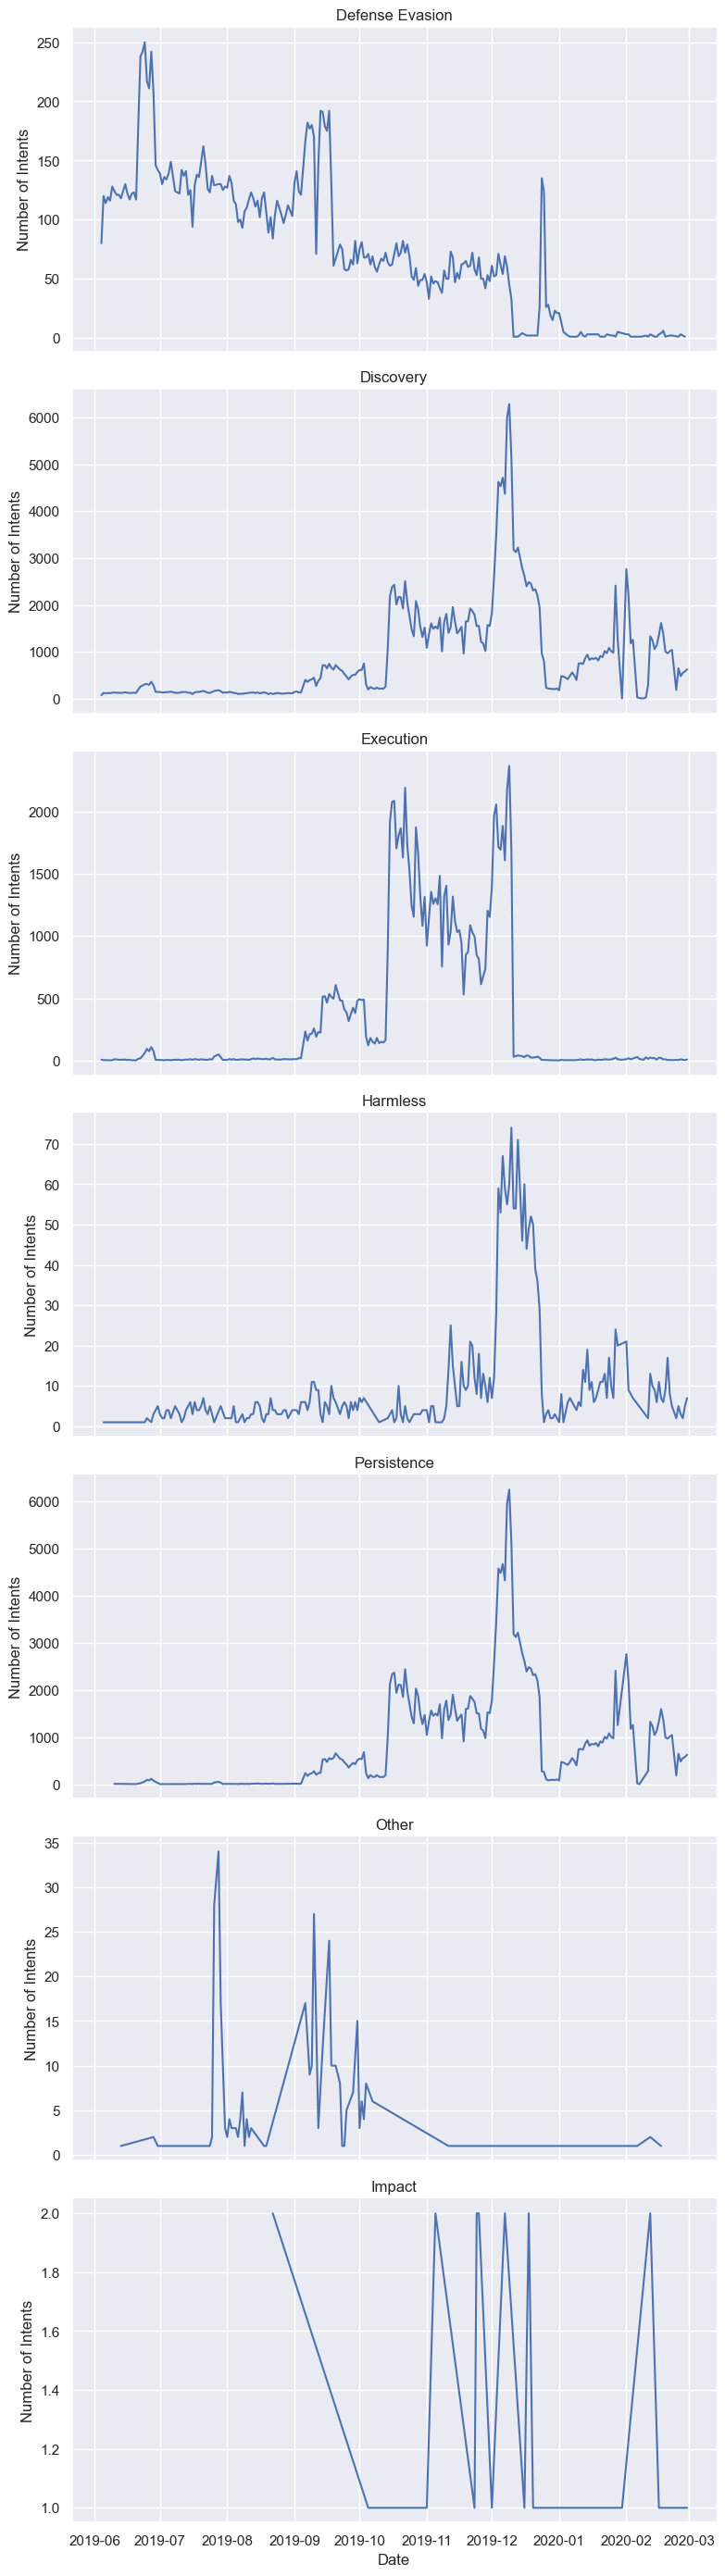

In [23]:
grid = sns.FacetGrid(df_intents_distribution, col="Set_Fingerprint", col_wrap=1, height=4, sharey=False, aspect=2)

grid.map(sns.lineplot, "first_timestamp", "Number_of_intents")

grid.set_axis_labels("Date", "Number of Intents")
grid.set_titles(col_template="{col_name}")

plt.show()

***REVIEW***

The distribution of intents unfolds as follows:

**Defense Evasion**:
No significant peaks noticed, with a few attacks observed between July and September 2019, remaining consistently low alongside 'Harmless', 'Impact', and 'Other' intents.

**Execution**:
Displays a sharp peak towards the end of 2019, notably in the last two months.

**Persistence and Discovery**:
Showcase an intriguing trend, reaching their highest peaks towards the end of 2019. These intents exhibit the highest frequency, notably surging towards the year-end, reaching maximum levels.

**1.5. How can text represented numerically? Try to convert the text into numerical representations
(vectors) through Bag of Words (BoW)**

A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

A vocabulary of known words.
A measure of the presence of known words.
It is called a bag-of-words , because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

In [24]:
if not os.path.isfile("df_features_bow.parquet"):
    count_vectorizer = CountVectorizer(min_df = 0.05)
    bow = count_vectorizer.fit_transform(df["full_session"].apply(lambda x : " ".join(x)))
    df_bow = pd.DataFrame(bow.toarray(), index=df.index, columns = list(count_vectorizer.vocabulary_.keys()))
    for feature in df_bow.columns:
        df_bow[feature] = normalize(df_bow[feature].values.reshape(-1,1), norm="l2", axis=0)
    df_bow = pd.concat([df, df_bow], axis=1)
    df_features_bow = df_bow.drop(columns=["session_id", "full_session", "first_timestamp"])
    # move Set Fingerprint column as last column of the dataframe
    # df_features_bow.insert(len(df_features_bow.columns)-1, "Set_Fingerprint", df_features_bow.pop("Set_Fingerprint"))
    df_features_bow.to_parquet("df_features_bow.parquet")
else:
    df_features_bow = pd.read_parquet("df_features_bow.parquet")

In [25]:
%run "train_test_split_sampled.ipynb" 
if not os.path.isfile("df_features_bow_sampled.parquet"):
    df_features_bow_sampled = sampling(df_features_bow)
    df_features_bow_sampled.to_parquet("df_features_bow_sampled.parquet")

**1.6. Associate each word in each attack session with its TF-IDF value (Term Frequency-Inverse Document Frequency)**

In [26]:
if not os.path.isfile("df_features_tfidf.parquet"):
    tfidf_vectorizer = TfidfVectorizer(min_df = 0.05)
    tfid = tfidf_vectorizer.fit_transform(df["full_session"].apply(lambda x : " ".join(x)))
    df_tfidf = pd.DataFrame(tfid.toarray(), index=df.index, columns = list(tfidf_vectorizer.vocabulary_.keys()))
    df_tfidf = pd.concat([df, df_tfidf], axis=1)
    df_features_tfidf = df_tfidf.drop(columns=["session_id", "full_session", "first_timestamp"])
    # move Set Fingerprint column as last column of the dataframe
    # df_features_tfidf.insert(len(df_features_tfidf.columns)-1, "Set_Fingerprint", df_features_tfidf.pop("Set_Fingerprint"))
    df_features_tfidf.to_parquet("df_features_tfidf.parquet")
else:
    df_features_tfidf = pd.read_parquet("df_features_tfidf.parquet")

In [27]:
%run "train_test_split_sampled.ipynb" 
if not os.path.isfile("df_features_tfidf_sampled.parquet"):
    df_features_tfidf_sampled = sampling(df_features_tfidf)
    df_features_tfidf_sampled.to_parquet("df_features_tfidf_sampled.parquet")

<br>
<b>Correlation Matrix</b>

In [30]:
# correlation_matrix_bow = df_features_bow.corr().abs()
# plt.figure(figsize=(50,50))
# sns.heatmap(correlation_matrix_bow, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
# plt.title('Correlation matrix')
# plt.show()

In [ ]:
# correlation_matrix_tfidf = df_features_tfidf.corr().abs()

# plt.figure(figsize=(50,50))
# sns.heatmap(correlation_matrix_tfidf, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
# plt.title('Correlation matrix')
# plt.show()

In [ ]:
# pca_bow = PCA()
# pca_bow.fit(df_features_bow)
# explained_variance_bow = pca_bow.explained_variance_ratio_

# plt.figure(figsize=(8,4))
# sns.lineplot(
#     data = explained_variance_bow,
#     marker = "o",
#     color = 'blue'
# )
# sns.set_theme(style="darkgrid")
# plt.xticks(range(0, len(explained_variance_bow), 5))
# plt.xlabel("Principal Components")
# plt.ylabel("Explained variance")
# plt.title("PCA")
# plt.show()

In [ ]:
# pca_bow = PCA(n_components=4)
# pca_result_bow = pca_bow.fit_transform(df_features_bow)
# pca_result_bow = pd.DataFrame(pca_result_bow, columns=[f'PC{i}' for i in range(pca_bow.n_components_)])
# pca_result_bow

In [ ]:
# pca_tfidf = PCA()
# pca_tfidf.fit(df_features_tfidf)
# explained_variance_tfidf = pca_tfidf.explained_variance_ratio_

# plt.figure(figsize=(8, 4))
# sns.lineplot(
#     data = explained_variance_tfidf,
#     marker="o",
#     color = 'blue'
# )
# # Set up Seaborn style
# sns.set_theme(style="darkgrid")
# plt.xticks(range(0, len(explained_variance_tfidf), 5))
# plt.xlabel("Principal Components")
# plt.ylabel("Explained variance")
# plt.title("PCA")
# plt.show()

In [ ]:
# pca_tfidf = PCA(n_components=3)
# pca_result_tfidf = pca_tfidf.fit_transform(df_features_tfidf)
# pca_result_tfidf = pd.DataFrame(pca_result_tfidf, columns=[f'PC{i}' for i in range(pca_tfidf.n_components_)])
# pca_result_tfidf